In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
import sys
from threading import Thread
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
import pyvistaqt as pvqt

# pv.set_jupyter_backend('pythreejs')
# pv.set_jupyter_backend('ipygany') # ipygany fails " Failed to use notebook backend: "
# pv.set_jupyter_backend('panel') # Doesn't work either, produces no output
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# Imports PIL module
import PIL # For applying the binary mask as a image texture to a mesh
# import opencv
from IPython.display import display # For manual display customization


In [2]:
# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *


In [3]:
# RoyMaze1:
mat_import_parent_path = Path(r'C:\Share\data\RoyMaze1\ExportedData')
# mat_import_file = r'C:\Share\data\RoyMaze1\ExportedData.mat'
position_mat_import_file = mat_import_parent_path.joinpath('positionAnalysis.mat')
data = import_mat_file(mat_import_file=position_mat_import_file)
                              
# # KevinMaze1
# mat_import_file = 'data/Kevin-maze1/PreFinalBinningResultWholeEnv.mat'
# data = import_mat_file(mat_import_file=mat_import_file)
# # 'spikeStruct'
# # 'speed','t','v' # 3243057×1

# # Achilles:
# main_data_path = Path(r'C:\Users\Pho\repos\PhoPy3DPositionAnalysis2021\data\Achilles_10252013')
# positionFilename = main_data_path.joinpath('ExportedData', 'Achilles_10252013_position.mat')
# positionFileFullpath = main_data_path.joinpath(positionFilename) # build a full filepath from the basepath
# data = import_mat_file(mat_import_file=positionFileFullpath)
# # print('data:'.format(data.keys()))
# data
# Get the position data:
t,x,y,speeds,dt,dx,dy = process_positionalAnalysis_data(data)
print('shapes - t: {}, x: {}, y: {}'.format(np.shape(t), np.shape(x), np.shape(y))) 
extrema_min, extrema_max = np.nanmin(x), np.nanmax(x)
print('for x: extrema_min: {}, extrema_max: {}'.format(extrema_min, extrema_max))
extrema_min, extrema_max = np.nanmin(y), np.nanmax(y)
print('for y: extrema_min: {}, extrema_max: {}'.format(extrema_min, extrema_max))

Loading matlab import file: C:\Share\data\RoyMaze1\ExportedData\positionAnalysis.mat...
done.
shapes - t: (324574,), x: (324574,), y: (324574,)
for x: extrema_min: 74.29166666666666, extrema_max: 649.3020833333334
for y: extrema_min: 160.54166666666666, extrema_max: 263.0


In [4]:
# Import the spikes
# spikes_mat_import_file = mat_import_parent_path.joinpath('spikesTable.mat')
spikes_mat_import_file = mat_import_parent_path.joinpath('spikesAnalysis.mat')
spikes_data = import_mat_file(mat_import_file=spikes_mat_import_file)
print(spikes_data.keys())
spike_matrix = spikes_data['spike_matrix']
spike_cells = spikes_data['spike_cells'][0]
print('spike_matrix: {}, spike_cells: {}'.format(np.shape(spike_matrix), np.shape(spike_cells)))
num_cells = np.shape(spike_matrix)[0]

Loading matlab import file: C:\Share\data\RoyMaze1\ExportedData\spikesAnalysis.mat...
done.
dict_keys(['spike_cells', 'spike_matrix'])
spike_matrix: (92, 4875), spike_cells: (92,)


In [5]:

print(np.shape(spike_cells))
# print(np.shape(spike_cells[0]))
# print(np.shape(spike_cells[1]))
# print(np.shape(spike_cells[2]))
# print(np.shape(spike_cells[3]))
# print(np.shape(spike_cells[4]))
# print(np.shape(spike_cells[5]))
# print(np.shape(spike_cells[6]))
# print(np.shape(spike_cells[7]))
# print(np.shape(spike_cells[8][:,0]))
# print(np.shape(extract_spike_timeseries(spike_cells[8])))

# extract_spike_timeseries(spike_cells[8])
spike_list = [extract_spike_timeseries(spike_cell) for spike_cell in spike_cells]
print(spike_list[0])

# Determine the x and y positions each spike occured for each cell
spike_positions_list = list()
for cell_id in np.arange(num_cells):
    spike_positions_list.append(np.vstack((np.interp(spike_list[cell_id], t, x), np.interp(spike_list[cell_id], t, y))))
    # spike_positions_list.append(np.hstack(x[spike_list[cell_id]], y[spike_list[cell_id]]))
    # spike_speed = speeds[spike_list[cell_id]]
    
print(np.shape(spike_positions_list[0])) # (2, 9297)
   
# print(spike_positions_list)
# spike_positions_list

(92,)
[3.12156667e+00 3.23186667e+00 7.65390000e+00 ... 3.53453575e+04
 3.53498584e+04 3.53500207e+04]
(2, 9297)


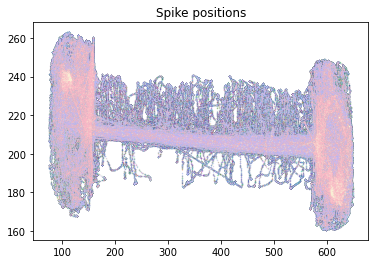

In [6]:
# Window

# Plot raster plot:
# Set different colors for each neuron

min_timestep = 0
max_timestep = 4000
active_spike_indices, active_spike_list, active_spike_positions_list = get_filtered_window(spike_list, spike_positions_list, min_timestep=0, max_timestep=400)

# cmap = get_cmap(num_cells)
cmap = generate_colormap(num_cells)

plt.figure()
for i, cell_spike_positions in enumerate(spike_positions_list):
   plt.scatter(cell_spike_positions[0,:], cell_spike_positions[1,:], s=0.1, color=cmap(i), alpha=0.2)

plt.title('Spike positions')
plt.show()

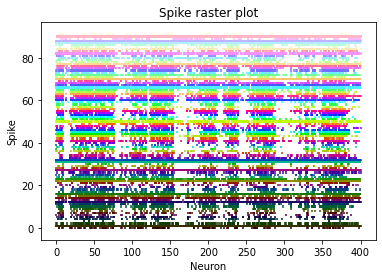

In [7]:
# colorCodes = np.broadcast_to(np.array([[0, 0, 0],
#                         [1, 0, 0],
#                         [0, 1, 0],
#                         [0, 0, 1],
#                         [1, 1, 0],
#                         [1, 0, 1],
#                         [0, 1, 1],
#                         [1, 0, 1]]), (num_cells, 3))
# print(np.shape(colorCodes))                    
# Set spike colors for each neuron
lineSize = [0.4, 0.3, 0.2, 0.8, 0.5, 0.6, 0.7, 0.9]                                  

        
# Draw a spike raster plot
# plt.eventplot(spike_cells[0])
colorCodes = [cmap(i) for i in np.arange(num_cells)]
plt.eventplot(active_spike_list, color=colorCodes)
# plt.eventplot(spike_matrix)    
# plt.eventplot(spike_matrix, color=colorCodes, linelengths = lineSize)     
# Provide the title for the spike raster plot
plt.title('Spike raster plot')
# Give x axis label for the spike raster plot
plt.xlabel('Neuron')
# Give y axis label for the spike raster plot
plt.ylabel('Spike')
# Display the spike raster plot
plt.show()

In [8]:
# ## Load Spiking Information:
# # load_path = Path('/Volumes/iNeo/Data/Rotation_3_Kamran Diba Lab/ClusterFreeAnalysisProject/Data/Achilles_10252013/ExportedData/Achilles_10252013_Output_All.npz')
# load_path = Path('data/Achilles_10252013/ExportedData/Achilles_10252013_Output_All.npz')
# ## Load Previously Saved Data:
# active_filename = load_path
# with open(active_filename, 'rb') as f:
#     loaded_data = np.load(f)
#     loaded_files = loaded_data.files
#     data_timestamps = loaded_data['data_timestamps']
#     data_position = loaded_data['spike_position_rate']
#     data_spikes = loaded_data['data_spikes']
#     spike_position_rate = loaded_data['spike_position_rate']
#     print('loaded loaded_data from {}'.format(active_filename))
    
# np.shape(data_spikes)

In [9]:
should_show_2d_plots = False

# Create a representation of the general maze layout by binning the data and then building a mask from all the points the animal ever traversed in the maze
# Output: negligably_traversed_maze_regions - an 80x80 binary mask that specifies which maze regions are never traversed.

# For the 1.6m track, we want bins of ~2cm -> 80 bins
num_position_bins = 80
# position_bins = np.linspace(0.0, 1.6, num_position_bins)
# digitized_x = np.digitize(x, position_bins)
# digitized_y = np.digitize(y, position_bins)

# smoothing_sigma = 2
smoothing_sigma = 4
img, extent, xedges, yedges = gen_2d_histrogram(x, y, smoothing_sigma)


xmidpoints = bin_edges_to_midpoints(xedges)
ymidpoints = bin_edges_to_midpoints(yedges)

## Get the histogram x that corresponds to each x, etc.
digitized_x = np.digitize(x, xedges)-1
digitized_y = np.digitize(y, yedges)-1

get_point_heatmap_value = lambda i, : img.T[(digitized_x[i]-1), (digitized_y[i]-1)]
point_heatmap_value = np.array(list(map(get_point_heatmap_value, range(0, len(digitized_x)))))

cmap,norm,point_colors = get_heatmap_color_vectors(point_heatmap_value)
print('point_heatmap_value: {}'.format(point_heatmap_value))

# print('img: {}'.format(np.shape(img)))
# img_mask = np.nonzero(img)
negligably_traversed_maze_regions = np.where(img < 25)
# print('negligably_traversed_maze_regions: {}'.format(np.shape(negligably_traversed_maze_regions)))
img_mask = img
img_mask[negligably_traversed_maze_regions] = np.nan


boosted_img = pow(img, 2)
# print('np.shape(img): {}, img: {}'.format(np.shape(img), img))

if should_show_2d_plots:
    fig, ax = plt.subplots(figsize=(15,6))
    plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)
    plt.colorbar()
    plt.title('Non-negligably Traversed Maze Regions')
    # xx, yy = np.meshgrid(position_bins, position_bins)
    # # xx, yy = np.meshgrid(digitized_x, digitized_y)
    # plt.imshow(z_values, cmap='hot', interpolation='nearest')
    # plt.hexbin(x, y, C=z_values, gridsize=gridsize, cmap=CM.jet, bins=None)
    # ax = sns.heatmap(z_values, linewidth=0.5)
    sns.jointplot(x=x, y=y, kind='hex')
    plt.show()

point_heatmap_value: [185.70297284 185.70297284 185.70297284 ... 171.79750638 171.79750638
 171.79750638]


xedges: (81,), yedges: (81,), extent: (4,), img: (80, 80)



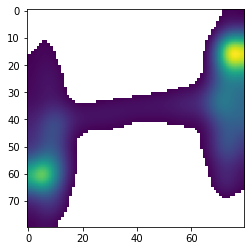

In [10]:
plt.imshow(img_mask)
print('xedges: {}, yedges: {}, extent: {}, img: {}\n'.format(np.shape(xedges), np.shape(yedges), np.shape(extent), np.shape(img)))
# print('xedges: {}, yedges: {}, extent: {}\n'.format(xedges, yedges, extent))
# plt.imshow(point_heatmap_value)
hist_grid_xx, hist_grid_yy = np.meshgrid(xmidpoints, ymidpoints)
hist_grid_zz = img

# Create and plot structured grid
occupancy_heatmap_grid = pv.StructuredGrid(hist_grid_xx, hist_grid_yy, hist_grid_zz)
occupancy_heatmap_grid.point_data['values'] = hist_grid_zz.flatten(order='F')
occupancy_heatmap_surface = occupancy_heatmap_grid.warp_by_scalar('values')
occupancy_heatmap_surface = occupancy_heatmap_surface.extract_surface()
occupancy_heatmap_surface.point_data['values'] = hist_grid_zz.flatten(order='F')
# mesh.plot()

origin = occupancy_heatmap_grid.center
origin[-1] -= occupancy_heatmap_grid.length / 3.0
occupancy_heatmap_floor_surface = occupancy_heatmap_surface.project_points_to_plane(origin=origin)
# occupancy_heatmap_floor_surface.plot(show_edges=True, show_grid=True, notebook=False)

# occupancy_heatmap_surface = pv.PolyData(occupancy_heatmap_grid)

# Apply an Elevation filter
# occupancy_heatmap_surface = occupancy_heatmap_grid.elevation()
# occupancy_heatmap_surface.plot(show_edges=True, show_grid=True, notebook=False)




# # occupancy_heatmap_grid.points = img
# p = pv.Plotter()
p = pvqt.BackgroundPlotter()
# p.background_color = 'black'
# origin = occupancy_heatmap_grid.center
# origin[-1] -= occupancy_heatmap_grid.length / 3.0
# projected = occupancy_heatmap_surface.project_points_to_plane(origin=origin)

# p.add_mesh(occupancy_heatmap_grid, show_edges=True)
# p.add_mesh(occupancy_heatmap_surface)
p.add_mesh(occupancy_heatmap_floor_surface)

# p.add_points(pdata)
# p.add_bounding_box()
# p.show_grid()
p.show()


In [11]:
# point_cloud = np.random.random((100, 3))
z = point_heatmap_value
# z = np.zeros_like(x)
point_cloud = np.vstack((x, y, z)).T
pdata = pv.PolyData(point_cloud)
pdata['occupancy heatmap'] = np.arange(np.shape(point_cloud)[0])

# create many spheres from the point cloud
sphere = pv.Sphere(radius=0.2, phi_resolution=3, theta_resolution=3)
pc = pdata.glyph(scale=False, geom=sphere)

In [12]:
# pc.plot(cmap='Reds')
# pc.plot()

# p = pv.Plotter()
# p.background_color = 'black'
# p.add_points(pdata)
# p.add_bounding_box()
# p.show_grid()
# p.show()


In [ ]:
p = pvqt.BackgroundPlotter() # Use just like you would a pv.Plotter() instance
p.background_color = 'black'
p.add_points(pdata)
p.add_bounding_box()
p.show_grid()
p.show()


In [13]:
# Plot the spikes on the track:
min_timestep = 0
max_timestep = 4000
active_spike_indices, active_spike_list, active_spike_positions_list = get_filtered_window(spike_list, spike_positions_list, min_timestep=0, max_timestep=400)

cell_index = 0
spike_series = active_spike_positions_list[cell_index]
# cell_id = int(active_spike_list[cell_index])
spike_series_times = active_spike_list[cell_index]
# print('active_spike_positions_list: {}'.format(np.shape(active_spike_positions_list)))
spike_series_positions = active_spike_positions_list[cell_index]

# print('cell_id: {}'.format(cell_id))
# print(np.shape(spike_series_times))

# # Plot the spike series along the time axis:
# cloud = pv.wrap(spike_series_times)
# # p = pv.plot(cloud, scalars=points[:, 2], render_points_as_spheres=True, point_size=50,
# #         opacity=spike_series_times[:, 0], cpos='xz')
# p = pv.plot(cloud, render_points_as_spheres=True, point_size=50,
#         opacity=0.6, cpos='xz')

p = pvqt.BackgroundPlotter() # Use just like you would a pv.Plotter() instance
# p = pv.Plotter() # Use just like you would a pv.Plotter() instance
# p.background_color = 'black'
# p.add_points(pdata)

# z = point_heatmap_value
z = np.zeros_like(spike_series_positions[0,:])
point_cloud = np.vstack((spike_series_positions[0,:], spike_series_positions[1,:], z)).T
pdata = pv.PolyData(point_cloud)

# create many spheres from the point cloud
sphere = pv.Sphere(radius=2.0, phi_resolution=3, theta_resolution=3)
pc = pdata.glyph(scale=False, geom=sphere)

p.add_points(pc)
p.show
# p.add_mesh(pc)
p.show()

In [ ]:
# pc.plot(cmap='Reds', notebook=True, jupyter_backend='ipygany') # ipygany fails " Failed to use notebook backend: "

In [ ]:
pc.plot(cmap='Reds', notebook=True, jupyter_backend='panel')

In [ ]:
## Plot the raw position points

# pvmesh = examples.download_topo_global()
pvmesh = pv.examples.download_st_helens()

ugrid = pvmesh.cast_to_unstructured_grid()

# Turn the PyVista mesh into a PolyMesh
mesh = PolyMesh.from_vtk(ugrid)

colored_mesh = IsoColor(mesh, min=-10421.0, max=6527.0)
warped_mesh = WarpByScalar(colored_mesh, input='altitude', factor=0.5e-5)

Scene([warped_mesh])

In [ ]:
# Projected Maze 2D Outline:
maze_outline_x = x
maze_outline_y = y


In [14]:
# Split the position data into equal sized chunks to be displayed at a single time. These will look like portions of the trajectory and be used to animate. # Chunk the data to create the animation.
# curr_view_window_length = 150 # View 5 seconds at a time (30fps)
curr_view_window_length = 30 # View 5 seconds at a time (30fps)
# The original length 324574 / 30 = 10819
t_fixedSegements,x_fixedSegements,y_fixedSegements,speeds_fixedSegements,dt_fixedSegements,dx_fixedSegements,dy_fixedSegements = process_chunk_equal_poritions_data(t, x, y, speeds, dt, dx, dy, curr_view_window_length)
print('shapes - t_fixedSegements: {}, x_fixedSegements: {}, y_fixedSegements: {}'.format(np.shape(t_fixedSegements), np.shape(x_fixedSegements), np.shape(y_fixedSegements)))
z_fixedSegements = np.zeros_like(x_fixedSegements)


shapes - t_fixedSegements: (10819, 30), x_fixedSegements: (10819, 30), y_fixedSegements: (10819, 30)


In [15]:
num_time_points = np.shape(x_fixedSegements)[0]
print('num_time_points: {}\n'.format(num_time_points))
animal_location_sphere = pv.Sphere(radius=2.3)
animal_location_direction_cone = pv.Cone()

#     animal_direction_arrow = pv.Arrow()
last_only_opacity_values = np.zeros([curr_view_window_length,])
last_only_opacity_values[-1] = 1.0

# last_only_opacity_values = np.zeros([1,curr_view_window_length])
# last_only_opacity_values[-1] = 1.0
gradually_fading_opacity_values = np.arange(curr_view_window_length)

# active_trail_opacity_values = last_only_opacity_values.copy()
active_trail_opacity_values = gradually_fading_opacity_values.copy()
# print('active_trail_opacity_values: {}\n'.format(np.shape(active_trail_opacity_values)))
    
## Slider with Callback Function Example:

# p = pvqt.BackgroundPlotter() # Use just like you would a pv.Plotter() instance

def on_slider_update_mesh(value):
    curr_i = int(value)
    # point_cloud_fixedSegements = np.vstack((x_fixedSegements, y_fixedSegements, z_fixedSegements)).T
    point_cloud_fixedSegements = np.column_stack((x_fixedSegements[curr_i,:], y_fixedSegements[curr_i,:], z_fixedSegements[curr_i,:]))
#     print('point_cloud_fixedSegements: {}\n'.format(np.shape(point_cloud_fixedSegements)))
    curr_animal_point = point_cloud_fixedSegements[-1,:] # Get the last point
#     actor = p.add_mesh(pyvista.Cube(), show_edges=True)
#     mesh = pv.PolyData(point_cloud_fixedSegements)
#     mesh.plot(point_size=10, style='points')
    pdata = pv.PolyData(point_cloud_fixedSegements) # a mesh
#     pdata['orig_sphere'] = np.arange(np.shape(point_cloud)[0])
    
#     print(last_only_opacity_values)
    
#     pdata.point_data['pho_fade_values'] = np.arange(np.shape(point_cloud_fixedSegements)[0])
    pdata.point_data['pho_fade_values'] = active_trail_opacity_values

    # create many spheres from the point cloud
    pc = pdata.glyph(scale=False, geom=animal_location_sphere)
    # pc.point_data['pho_fade_values'] = active_trail_opacity_values
        
    # plines = p.add_lines(point_cloud_fixedSegements, name='animal_trajectory_lines', color='orange')
    # plines.point_data['pho_fade_values'] = active_trail_opacity_values
    #     p.add_mesh(pc, name='animal_location', color="red", opacity='linear', scalars='pho_fade_values', nan_opacity=0.0)
    # p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity=0.8, nan_opacity=0.0)
    # p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity="pho_fade_values", nan_opacity=0.0)

    p.add_mesh(pc, name='animal_location', color='red', ambient=0.6, opacity=0.8, nan_opacity=0.0, render_lines_as_tubes=True)
#     p.add_mesh(animal_location_sphere, color="grey", ambient=0.6, opacity=0.5, show_edges=False)
    
#     # Create spline with 1000 interpolation points
#     spline = pv.Spline(point_cloud_fixedSegements)
# #     # add scalars to spline and plot it
#     spline["scalars"] = np.arange(spline.n_points)
#     tube = spline.tube(radius=0.1)
# #     tube.plot(smooth_shading=True)
#     p.add_mesh(tube, name='tube')

#     sphere = pv.Sphere(phi_resolution=res, theta_resolution=res)
#     p.add_mesh(sphere, name='sphere', show_edges=True)
    return


        
p = pvqt.BackgroundPlotter() # Use just like you would a pv.Plotter() instance
# p = pv.Plotter() # Use just like you would a pv.Plotter() instance
# p.background_color = 'black'
p.add_points(pdata)
# p.add_slider_widget(on_slider_update_mesh, [0, (num_time_points-1)], title='Trajectory Timestep', event_type='always', style='modern')
# active_frame_range = np.arange(num_time_points) # All frames
active_frame_range = np.arange(num_time_points) # All frames
# active_frame_range = np.arange(100) # Only 100 frames
# active_frame_range = range(100) # Only 100 frames                  
# make_mp4_from_plotter(p, active_frame_range, on_slider_update_mesh, filename='complete_plotting.mp4')
# p.add_bounding_box()
# p.show_grid()
# p.add_axes(line_width=5, labels_off=True)
# p.hide_axes()
# p.show()
                  
print('all done!')

num_time_points: 10819

all done!


In [16]:
# scales = {
#     'x': bqplot.scales.LinearScale(min=10**-3, max=10**3),
#     'y': bqplot.scales.LinearScale(min=-3, max=3),
#     'z': bqplot.scales.LinearScale(min=-3, max=3),
# }
# color_scale = bqplot.scales.ColorScale(min=0, max=3, colors=["#f00", "#0f0", "#00f"])